In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime, pytz, sys
import influxdb_client, os, time
from influxdb_client import InfluxDBClient, Point, WritePrecision
from influxdb_client.client.write_api import SYNCHRONOUS

In [2]:
token = "XjJ1RcXCbFce1y747Htd_gsALsEcoeB72pbbUYMAf4C3RLdvQRIZJzraDzc_43cx0yQtsC9u5ikhOLNw2CiPig=="
token = 'c1naAAYSPJadt_jrVEuJLGqODdjn89P7kK-mSYcYtAPKesRgnF7mfRZNg6x7h_3Zzu3znV7Qwyj0-oeuTH83qQ=='
org = "SLACBL"
url = "http://localhost:8087"
local = pytz.timezone("America/Los_Angeles")

def db_dt(dt):
    return db_time(dt.year, dt.month, dt.day, dt.hour, dt.minute, int(dt.second))
def db_time(year,month,day,hour,minute,sec):
    dt = datetime.datetime(year,month,day,hour,minute,sec)
    dt_PT = local.localize(dt, is_dst=None)
    dt_utc = dt_PT.astimezone(pytz.utc)
    return datetime.datetime.strftime(dt_utc,"%Y-%m-%dT%H:%M:%SZ")

# May 6-7 2024 cooldown

In [32]:
start_dt = datetime.datetime(2024,5,6,16,0,0)
end_dt   = datetime.datetime(2024,5,9,0,0,0)

# start_dt = datetime.datetime(2024,5,7,0,0,0)
# end_dt   = datetime.datetime(2024,5,7,1,0,0)

def GetDataFromInflux( start_dt, end_dt):
    data = []
    with InfluxDBClient(url="http://localhost:8087", token=token, org=org) as client:
        query = """from(bucket: "CryoLabData")
          |> range(start: %s, stop: %s)
          |> filter(fn: (r) => r["_measurement"] == "EC_Cham" or r["_measurement"] == "EC_Set" or r["_measurement"] == "EC_User" or r["_measurement"] == "LJT7_LNMass" or r["_measurement"] == "LJT_Resistance" or r["_measurement"] == "Electrometer")"""
        query = query%(db_dt(start_dt), db_dt(end_dt))
        tables = client.query_api().query(query, org=org)
    
        for table in tables:
            for record in table.records:
                data.append(np.array([record['_time'].astimezone(pytz.timezone("America/Los_Angeles")),\
                                      record['_measurement'],\
                                      record['_field'],\
                                      record["_value"] ]))
            
    data_R = np.array(data)

    return data_R

data_R = GetDataFromInflux( start_dt, end_dt )



In [33]:
print(start_dt)
print(end_dt)

2024-05-06 16:00:00
2024-05-09 00:00:00


In [34]:
data_R.shape

(259670, 4)

In [35]:
np.unique(data_R[:,1])

array(['EC_Cham', 'EC_Set', 'EC_User', 'LJT7_LNMass', 'LJT_Resistance'],
      dtype=object)

In [36]:
def convert_data_to_dict( data_array ):
    data_names = np.unique(data_array[:,1])
    
    output_dict = {}
    
    for name in data_names:
        mask = (data_array[:,1] == name)
        
        output_dict[name] = np.vstack((data_array[mask,0], data_array[mask,3]))

    return output_dict
    

In [37]:
output_dict = convert_data_to_dict( data_R )
output_dict.keys()

dict_keys(['EC_Cham', 'EC_Set', 'EC_User', 'LJT7_LNMass', 'LJT_Resistance'])

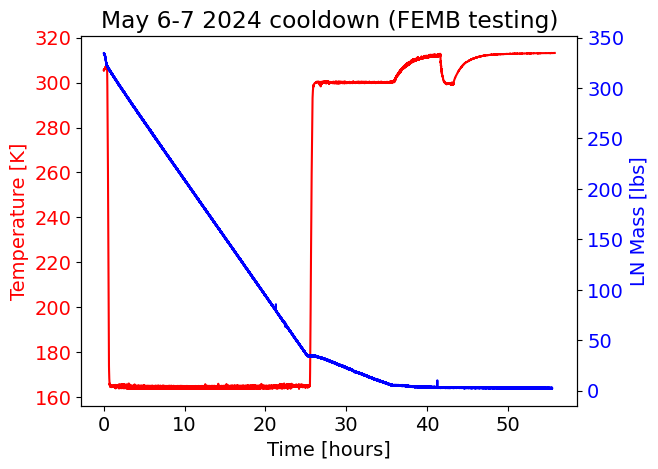

In [38]:
import matplotlib.dates as mdates

def ConvertDatesToHours( dates, reference_date = None ):
    times_in_days = mdates.date2num( dates )
    if reference_date is not None:
        ref_date = mdates.date2num( reference_date )
        return (times_in_days - ref_date)*24
    else:
        return (times_in_days - times_in_days[0])*24

# def GetUsageRageInTimeRange

plt.title('May 6-7 2024 cooldown (FEMB testing)')

plt.rcParams['font.size'] = 14

plt.plot(ConvertDatesToHours(output_dict['EC_User'][0]),output_dict['EC_User'][1],'r')
plt.ylabel('Temperature [K]', color='r')
plt.gca().tick_params(axis='y',labelcolor='r')
plt.xlabel('Time [hours]')

ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(ConvertDatesToHours(output_dict['LJT7_LNMass'][0]),output_dict['LJT7_LNMass'][1],'-b')
ax2.set_ylabel('LN Mass [lbs]', color='b')
ax2.tick_params(axis='y', labelcolor='b')
# ax.xaxis.grid(True)

# plt.figure(2)
# plt.plot(ConvertDatesToHours(data_temp[:,0]),data_temp[:,1])
# plt.ylabel('Temperature [K]')
# plt.xlabel('Time [hours]')
plt.savefig('2024_05_06_cooldown_temp_and_LNMass.png',dpi=200,bbox_inches='tight')

In [39]:
def GetUsageRateInTimeRange( output_dict, min_hr, max_hr, reference_time = None):
    time_hrs = ConvertDatesToHours(output_dict['LJT7_LNMass'][0], reference_date=reference_time)
    mass_mask = (time_hrs > min_hr)*(time_hrs < max_hr)

    y = output_dict['LJT7_LNMass'][1]

    p = np.polyfit(time_hrs[mass_mask].astype('float'), y[mass_mask].astype('float'), 1)

    time_hrs = ConvertDatesToHours(output_dict['EC_User'][0], reference_date=reference_time)
    temp_mask = (time_hrs > min_hr)*(time_hrs < max_hr)
    y = output_dict['EC_User'][1]
    temp = np.mean(y[temp_mask].astype('float'))

    
    return [temp, p[0]]



In [40]:
GetUsageRateInTimeRange( output_dict, 10,20)

[164.46770833333332, -11.453381889730151]

In [41]:
GetUsageRateInTimeRange( output_dict, 30,32)

[300.0143532684284, -3.3187035917451846]

# December 15 cooldown (resistor testing)

In [60]:
start_dt = datetime.datetime(2023,12,15,9,0,0)
end_dt   = datetime.datetime(2023,12,15,21,0,0)

# data_R = GetDataFromInflux( start_dt, end_dt ) 

# print(data_R)






In [61]:
output_dict = convert_data_to_dict( GetDataFromInflux( start_dt, end_dt ) )

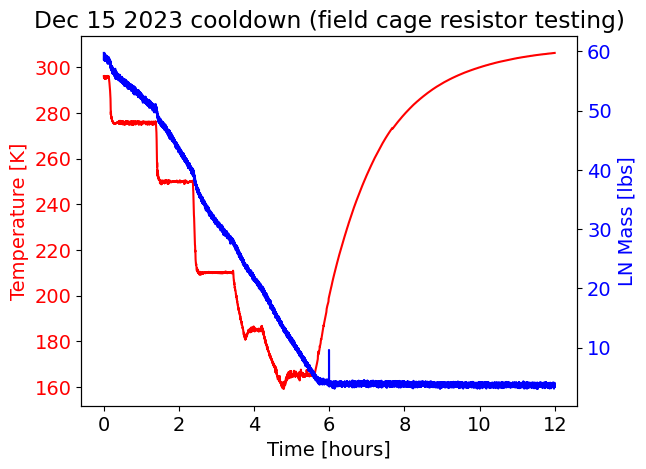

In [62]:
plt.title('Dec 15 2023 cooldown (field cage resistor testing)')

plt.rcParams['font.size'] = 14

plt.plot(ConvertDatesToHours(output_dict['EC_User'][0]),output_dict['EC_User'][1],'r')
plt.ylabel('Temperature [K]', color='r')
plt.gca().tick_params(axis='y',labelcolor='r')
plt.xlabel('Time [hours]')

ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(ConvertDatesToHours(output_dict['LJT7_LNMass'][0]),output_dict['LJT7_LNMass'][1],'-b')
ax2.set_ylabel('LN Mass [lbs]', color='b')
ax2.tick_params(axis='y', labelcolor='b')
plt.savefig('2023_12_15_cooldown_temp_and_LNMass.png',dpi=200,bbox_inches='tight')

In [45]:
GetUsageRateInTimeRange( output_dict, 5.4,5.5)

[165.58583333333328, -8.893446823841536]

In [46]:
GetUsageRateInTimeRange( output_dict, 8,12)

[297.7878645833333, -0.03844042801380535]

# Dec 12 cooldown (field cage resistor testing)

In [63]:
start_dt = datetime.datetime(2023,12,12,8,0,0)
end_dt   = datetime.datetime(2023,12,12,23,0,0)

In [64]:
output_dict = convert_data_to_dict( GetDataFromInflux( start_dt, end_dt ) )

(0.0, 9.0)

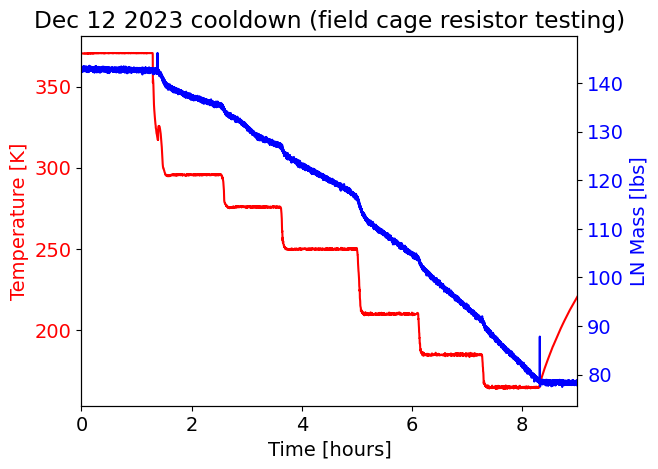

In [69]:
plt.title('Dec 12 2023 cooldown (field cage resistor testing)')

plt.rcParams['font.size'] = 14

plt.plot(ConvertDatesToHours(output_dict['EC_User'][0]),output_dict['EC_User'][1],'r')
plt.ylabel('Temperature [K]', color='r')
plt.gca().tick_params(axis='y',labelcolor='r')
plt.xlabel('Time [hours]')

ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(ConvertDatesToHours(output_dict['LJT7_LNMass'][0]),output_dict['LJT7_LNMass'][1],'-b')
ax2.set_ylabel('LN Mass [lbs]', color='b')
ax2.tick_params(axis='y', labelcolor='b')
plt.xlim(0.,9.)
# plt.savefig('2023_12_12_cooldown_temp_and_LNMass.png',dpi=200,bbox_inches='tight')

In [66]:
GetUsageRateInTimeRange( output_dict, 7.6,7.7)

[164.52083333333334, -10.59976855718969]

In [67]:
GetUsageRateInTimeRange( output_dict, 10,12)

[282.64650819444444, -0.07530315469418591]

In [68]:
GetUsageRateInTimeRange( output_dict, 6.5,6.8)

[184.65722222222223, -9.857682394245408]

In [73]:
print(GetUsageRateInTimeRange( output_dict, 2,2.2))
print(GetUsageRateInTimeRange( output_dict, 4.2,4.3))
print(GetUsageRateInTimeRange( output_dict, 5.7,5.8))
print(GetUsageRateInTimeRange( output_dict, 6.7,6.8))
print(GetUsageRateInTimeRange( output_dict, 7.8,8.0))

[295.6065277777777, -3.3585593343271922]
[249.84416666666664, -6.221934679946018]
[209.8133333333333, -8.691106792165266]
[184.70638888888885, -10.197243456645872]
[164.5884722222222, -10.835724725644022]


# July 25 cooldown tile resistance setup testing

In [87]:
start_dt = datetime.datetime(2023,7,25,14,0,0)
end_dt   = datetime.datetime(2023,7,26,14,0,0)

In [88]:
output_dict = convert_data_to_dict( GetDataFromInflux( start_dt, end_dt ) )

In [89]:



ConvertDatesToHours(output_dict['EC_User'][0])

array([0.00000000e+00, 2.77777782e-03, 5.55555554e-03, ...,
       1.82000000e+01, 1.82027778e+01, 1.82055556e+01])

In [90]:
output_dict['EC_User'][0]

array([datetime.datetime(2023, 7, 25, 15, 25, 23, tzinfo=<DstTzInfo 'America/Los_Angeles' PDT-1 day, 17:00:00 DST>),
       datetime.datetime(2023, 7, 25, 15, 25, 33, tzinfo=<DstTzInfo 'America/Los_Angeles' PDT-1 day, 17:00:00 DST>),
       datetime.datetime(2023, 7, 25, 15, 25, 43, tzinfo=<DstTzInfo 'America/Los_Angeles' PDT-1 day, 17:00:00 DST>),
       ...,
       datetime.datetime(2023, 7, 26, 9, 37, 23, tzinfo=<DstTzInfo 'America/Los_Angeles' PDT-1 day, 17:00:00 DST>),
       datetime.datetime(2023, 7, 26, 9, 37, 33, tzinfo=<DstTzInfo 'America/Los_Angeles' PDT-1 day, 17:00:00 DST>),
       datetime.datetime(2023, 7, 26, 9, 37, 43, tzinfo=<DstTzInfo 'America/Los_Angeles' PDT-1 day, 17:00:00 DST>)],
      dtype=object)

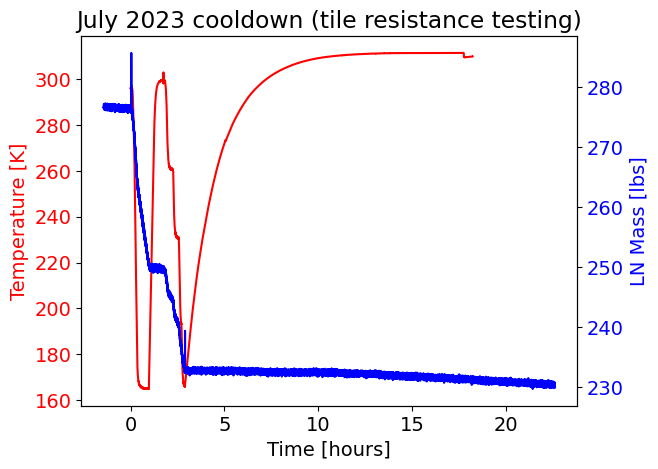

In [91]:
plt.title('July 2023 cooldown (tile resistance testing)')

plt.rcParams['font.size'] = 14

plt.plot(ConvertDatesToHours(output_dict['EC_User'][0]),output_dict['EC_User'][1],'r')
plt.ylabel('Temperature [K]', color='r')
plt.gca().tick_params(axis='y',labelcolor='r')
plt.xlabel('Time [hours]')

ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(ConvertDatesToHours(output_dict['LJT7_LNMass'][0],reference_date=output_dict['EC_User'][0][0]),output_dict['LJT7_LNMass'][1],'-b')
ax2.set_ylabel('LN Mass [lbs]', color='b')
ax2.tick_params(axis='y', labelcolor='b')
plt.savefig('2023_07_25_cooldown_temp_and_LNMass.png',dpi=200,bbox_inches='tight')
# plt.xlim(0.,5.)

In [92]:
GetUsageRateInTimeRange( output_dict, 0.8, 0.9, reference_time=output_dict['EC_User'][0][0])

[165.02277777777778, -22.51543635020515]

In [93]:
GetUsageRateInTimeRange( output_dict, 10, 20, reference_time=output_dict['EC_User'][0][0])

[310.9563008130081, -0.16306768652544668]

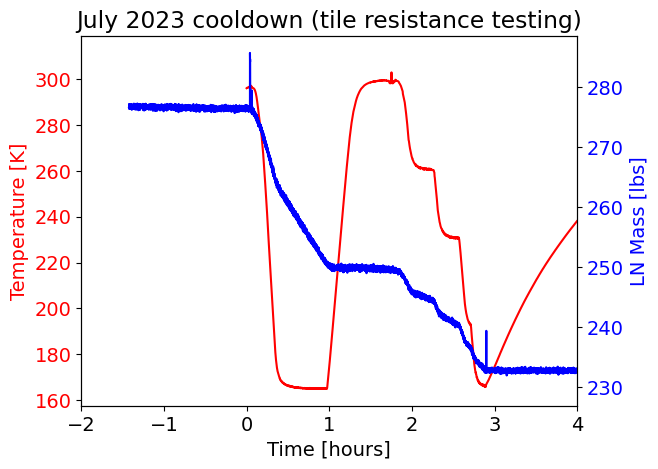

In [94]:
plt.title('July 2023 cooldown (tile resistance testing)')

plt.rcParams['font.size'] = 14

plt.plot(ConvertDatesToHours(output_dict['EC_User'][0]),output_dict['EC_User'][1],'r')
plt.ylabel('Temperature [K]', color='r')
plt.gca().tick_params(axis='y',labelcolor='r')
plt.xlabel('Time [hours]')

ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(ConvertDatesToHours(output_dict['LJT7_LNMass'][0],reference_date=output_dict['EC_User'][0][0]),output_dict['LJT7_LNMass'][1],'-b')
ax2.set_ylabel('LN Mass [lbs]', color='b')
ax2.tick_params(axis='y', labelcolor='b')
plt.xlim(-2.,4.)
plt.savefig('2023_07_25_cooldown_temp_and_LNMass_zoomed.png',dpi=200,bbox_inches='tight')
# plt.xlim(0.,5.)

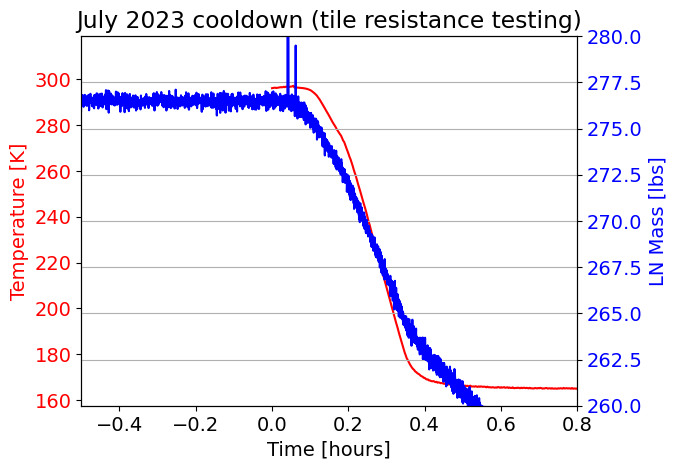

In [98]:
plt.title('July 2023 cooldown (tile resistance testing)')

plt.rcParams['font.size'] = 14

plt.plot(ConvertDatesToHours(output_dict['EC_User'][0]),output_dict['EC_User'][1],'r')
plt.ylabel('Temperature [K]', color='r')
plt.gca().tick_params(axis='y',labelcolor='r')
plt.xlabel('Time [hours]')

ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(ConvertDatesToHours(output_dict['LJT7_LNMass'][0],reference_date=output_dict['EC_User'][0][0]),output_dict['LJT7_LNMass'][1],'-b')
ax2.set_ylabel('LN Mass [lbs]', color='b')
ax2.tick_params(axis='y', labelcolor='b')
plt.xlim(-.5,0.8)
ax2.set_ylim(260.,280.)
ax2.grid()
plt.savefig('2023_07_25_cooldown_temp_and_LNMass_zoomed_02.png',dpi=200,bbox_inches='tight')

# plt.xlim(0.,5.)

# Inspecting long-term trends of dewar boiloff

In [74]:
start_dt = datetime.datetime(2023,10,24,0,0,0)
end_dt   = datetime.datetime(2023,11,5,0,0,0)

In [75]:
output_dict = convert_data_to_dict( GetDataFromInflux( start_dt, end_dt ) )

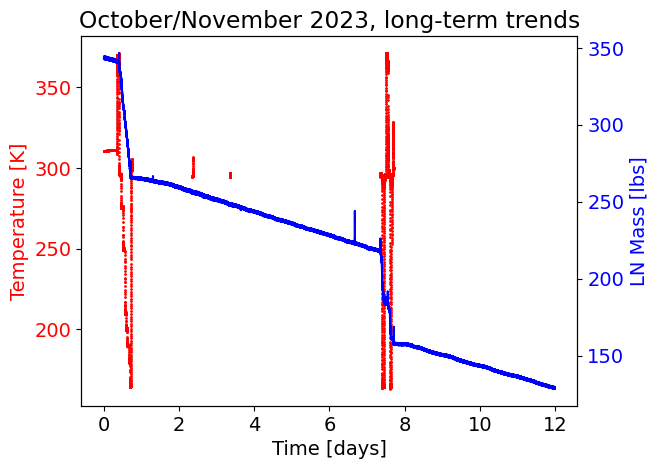

In [81]:
plt.title('October/November 2023, long-term trends')

plt.rcParams['font.size'] = 14

plt.plot(ConvertDatesToHours(output_dict['EC_User'][0])/24,output_dict['EC_User'][1],'or',markersize=1)
plt.ylabel('Temperature [K]', color='r')
plt.gca().tick_params(axis='y',labelcolor='r')
plt.xlabel('Time [days]')

ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(ConvertDatesToHours(output_dict['LJT7_LNMass'][0],reference_date=output_dict['EC_User'][0][0])/24,output_dict['LJT7_LNMass'][1],'-b')
ax2.set_ylabel('LN Mass [lbs]', color='b')
ax2.tick_params(axis='y', labelcolor='b')
plt.savefig('2023_10_24-2023_11_05_long_term_boiloff_data.png',dpi=200,bbox_inches='tight')




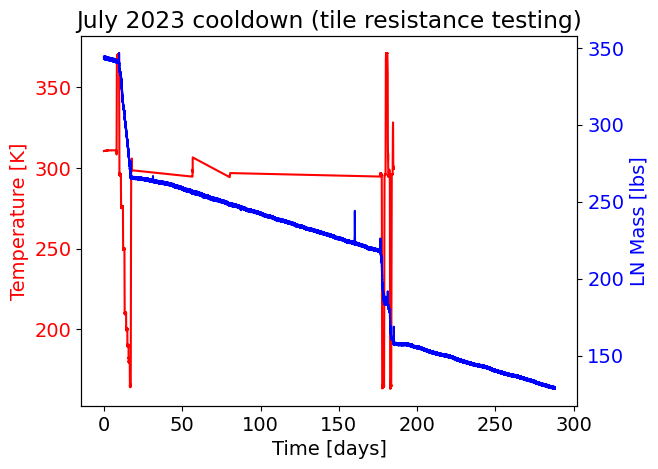

In [82]:
plt.title('July 2023 cooldown (tile resistance testing)')

plt.rcParams['font.size'] = 14

plt.plot(ConvertDatesToHours(output_dict['EC_User'][0]),output_dict['EC_User'][1],'r')
plt.ylabel('Temperature [K]', color='r')
plt.gca().tick_params(axis='y',labelcolor='r')
plt.xlabel('Time [days]')

ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(ConvertDatesToHours(output_dict['LJT7_LNMass'][0],reference_date=output_dict['EC_User'][0][0]),output_dict['LJT7_LNMass'][1],'-b')
ax2.set_ylabel('LN Mass [lbs]', color='b')
ax2.tick_params(axis='y', labelcolor='b')



In [83]:
GetUsageRateInTimeRange( output_dict, 100, 150, reference_time=output_dict['EC_User'][0][0])

C:\Users\bglen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\bglen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[nan, -0.3169109166698703]

(200.0, 260.0)

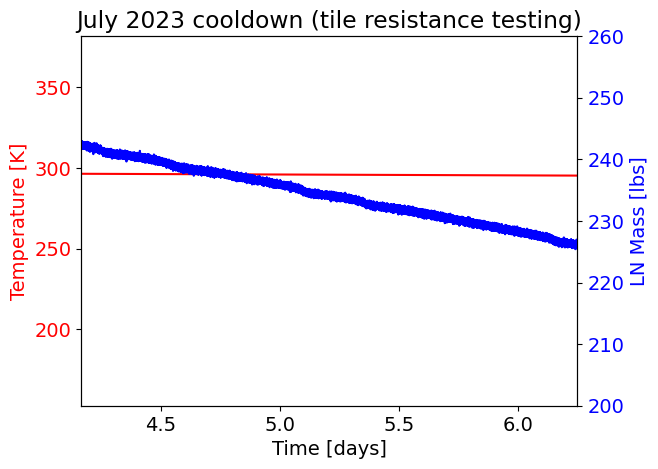

In [86]:
plt.title('July 2023 cooldown (tile resistance testing)')

plt.rcParams['font.size'] = 14

plt.plot(ConvertDatesToHours(output_dict['EC_User'][0])/24,output_dict['EC_User'][1],'r')
plt.ylabel('Temperature [K]', color='r')
plt.gca().tick_params(axis='y',labelcolor='r')
plt.xlabel('Time [days]')

ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(ConvertDatesToHours(output_dict['LJT7_LNMass'][0],reference_date=output_dict['EC_User'][0][0])/24,output_dict['LJT7_LNMass'][1],'-b')
ax2.set_ylabel('LN Mass [lbs]', color='b')
ax2.tick_params(axis='y', labelcolor='b')

plt.xlim(100/24,150/24)
ax2.set_ylim(200.,260.)
